# Maximum mean discrepancy 與 解碼性能之關係

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import os
import itertools
from dataPreprocess import read_dataset
from model_tf import simpleDecodeModel

In [2]:
def r_square(pred:np.ndarray, true:np.ndarray) -> np.ndarray:
    ss_tot = np.sum((true - np.mean(true, axis=0)) ** 2, axis=0)
    ss_res = np.sum((true - pred) ** 2, axis=0)
    r_square = np.ones_like(ss_tot) - (ss_res / ss_tot)

    return r_square

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    
    n_samples = int(source.shape[0]) + int(target.shape[0])
    total = np.concatenate([source, target], axis=0)
   
    bs_cnt = int(total.shape[0])
    feature_cnt = int(total.shape[1])

    total0 = np.broadcast_to(np.expand_dims(total, axis=0), shape=[bs_cnt, bs_cnt, feature_cnt])
    total1 = np.broadcast_to(np.expand_dims(total, axis=1), shape=[bs_cnt, bs_cnt, feature_cnt])
    L2_distance = np.sum((total0-total1)**2, axis=2) 

 
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = np.sum(L2_distance) / (n_samples**2-n_samples)
   
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

   
    kernel_val = [np.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    
    return sum(kernel_val)

def maximumMeanDiscrepancy(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n = int(source.shape[0])
    m = int(target.shape[0])

    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
   
    XX = kernels[:n, :n] 
    YY = kernels[n:, n:]
    XY = kernels[:n, n:]
    YX = kernels[n:, :n]
    
    XX = np.reshape(np.sum(np.divide(XX, n * n), axis=1), [1, -1])  # K_ss矩阵，Source<->Source
    XY = np.reshape(np.sum(np.divide(XY, -n * m), axis=1), [1, -1]) # K_st矩阵，Source<->Target
    YX = np.reshape(np.sum(np.divide(YX, -m * n), axis=1), [1, -1]) # K_ts矩阵,Target<->Source
    YY = np.reshape(np.sum(np.divide(YY, m * m), axis=1), [1, -1]) # K_tt矩阵,Target<->Target

    	
    loss = np.sum(XX + XY) + np.sum(YX + YY)
    
    return loss

In [5]:
df = pd.DataFrame(columns=['source_r_square', 'target_r_square', 'axis', 'movement', 'sourceSessionIndex', 'targetSessionIndex', 'normalizedMethod', 'maximumMeanDiscrepancy'])
df.to_csv('./results/experiments/experiments_maximumMeanDiscrepancy.csv', index=False)

In [ ]:
for n in range(1):
    for sourceSessionIndex in range(37):
        folderPath = './data'
        fileList = sorted([i for i in os.listdir(folderPath) if i.endswith('zip')])
        
        sourceSession = fileList[sourceSessionIndex]
        sourceDataset = read_dataset(os.path.join(folderPath, sourceSession), ['velocity_x', 'velocity_y'])
        
         # model
        model = simpleDecodeModel()
        model.compile(optimizer = 'adam', run_eagerly=True, loss='mse')

        # prepare dataset
        TRAIN_COUNT = 5000
        train_x = sourceDataset['m1'][:TRAIN_COUNT]
        train_y = sourceDataset['movement'][:TRAIN_COUNT]

        test_x = sourceDataset['m1'][TRAIN_COUNT:]
        test_y = sourceDataset['movement'][TRAIN_COUNT:]
        
            
        # fit
        model.fit(x=sourceDataset['m1'][:TRAIN_COUNT], y=sourceDataset['movement'][:TRAIN_COUNT], \
            batch_size=256, epochs=100, shuffle=True, verbose=1)
        
        
        model.return_feature = False
        source_pred = model.predict(x=sourceDataset['m1'][TRAIN_COUNT:])
        source_true = sourceDataset['movement'][TRAIN_COUNT:]
        source_r2 = [r_square(pred=source_pred[:, i], true=source_true[:, i]) for i in range(source_pred.shape[-1])]
        
        for targetSessionIndex in range(37):
            targetSession = fileList[targetSessionIndex]
            targetDataset = read_dataset(os.path.join(folderPath, targetSession), ['velocity_x', 'velocity_y'])

            print('count =>', n, 'sourceIndex =>', sourceSessionIndex, 'targetIndex =>', targetSessionIndex)

            # pred
            model.return_feature = False           

            target_pred = model.predict(x=targetDataset['m1'][TRAIN_COUNT:])
            target_true = targetDataset['movement'][TRAIN_COUNT:]
            target_r2 = [r_square(pred=target_pred[:, i], true=target_true[:, i]) for i in range(target_pred.shape[-1])]

            model.return_feature = True
            mmd_loss = 0.0
            for i in range(0, TRAIN_COUNT, 1000):
                _, source_feature = model.predict(x=sourceDataset['m1'][i:i+1000])
                _, target_feature = model.predict(x=targetDataset['m1'][i:i+1000])
                mmd_loss += maximumMeanDiscrepancy(source_feature, target_feature)
            mmd_loss /= 5

            # save
            result = pd.DataFrame({
                'source_r_square': [source_r2],
                'target_r_square': [target_r2],
                'axis': [['x', 'y']],
                'movement': 'velocity',
                'sourceSessionIndex': [sourceSessionIndex],
                'targetSessionIndex': [targetSessionIndex],
                'normalizedMethod': ['None'],
                'maximumMeanDiscrepancy': [mmd_loss]
            })

            result = result.explode(['axis', 'source_r_square', 'target_r_square']).reset_index(drop=True)

            result.to_csv('./results/experiments/experiments_maximumMeanDiscrepancy.csv', index=False, header=False, mode='a')

# 讀檔畫圖

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dataPreprocess import read_dataset

sns.set_theme(style='whitegrid', font_scale=2)

Text(0.5, 1.0, 'Fixed model performance')

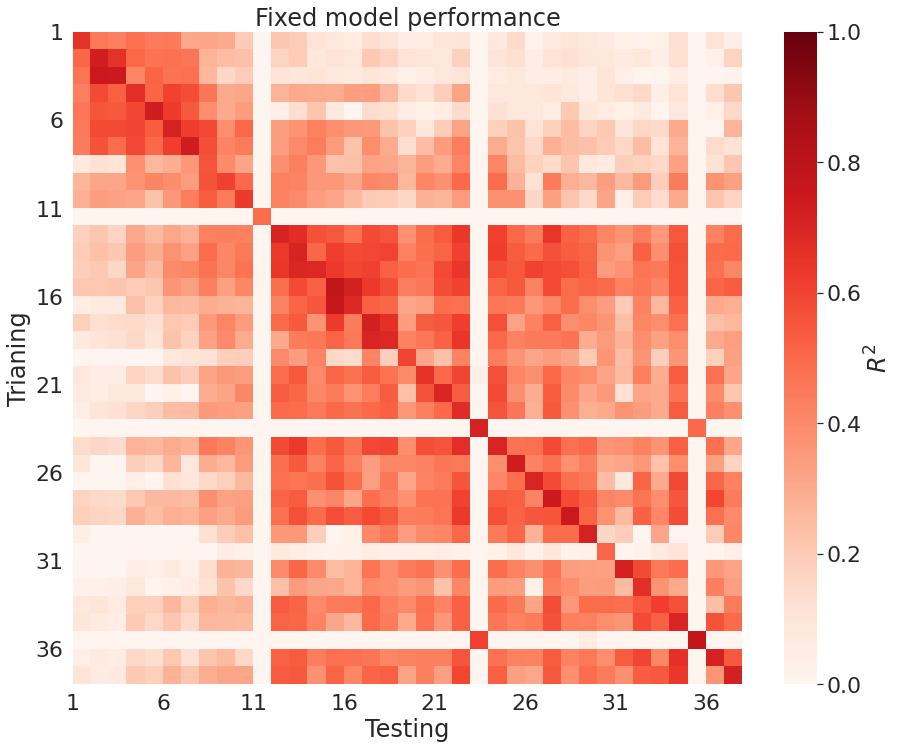

In [3]:
df = pd.read_csv('./results/experiments/experiments_maximumMeanDiscrepancy.csv')

r2 = np.full([37, 37, 2], fill_value=np.nan)

df = df.groupby(['axis', 'movement', 'sourceSessionIndex', 'targetSessionIndex']).mean().reset_index()

for sourceIndex in range(37):
    for targetIndex in range(37):  
        if sourceIndex == targetIndex:
            continue
        r2[sourceIndex, targetIndex, 0] = \
            df[(df['sourceSessionIndex'] == sourceIndex) & (df['targetSessionIndex'] == targetIndex) & (df['axis'] == 'x')]['target_r_square']
        r2[sourceIndex, targetIndex, 1] = \
            df[(df['sourceSessionIndex'] == sourceIndex) & (df['targetSessionIndex'] == targetIndex) & (df['axis'] == 'y')]['target_r_square']
for index in range(36):   
    r2[index, index, 0] = \
        df[(df['sourceSessionIndex'] == index) & (df['targetSessionIndex'] == index+1) & (df['axis'] == 'x')]['source_r_square']
    r2[index, index, 1] = \
        df[(df['sourceSessionIndex'] == index) & (df['targetSessionIndex'] == index+1) & (df['axis'] == 'y')]['source_r_square']

r2[36, 36, 0] = \
    df[(df['sourceSessionIndex'] == 36) & (df['targetSessionIndex'] == 35) & (df['axis'] == 'x')]['source_r_square']
r2[36, 36, 1] = \
    df[(df['sourceSessionIndex'] == 36) & (df['targetSessionIndex'] == 35) & (df['axis'] == 'y')]['source_r_square']

plt.figure(figsize=(15, 12))
g = sns.heatmap(r2[:, :, 0], cmap='Reds', vmin=0, vmax=1, cbar_kws={'label': '$R^2$'})
g.set(xticks=range(0, 37, 5), xticklabels=range(1, 38, 5), xlabel='Testing')
g.set(yticks=range(0, 37, 5), yticklabels=range(1, 38, 5), ylabel='Trianing')
g.set_yticklabels(range(1, 38, 5), rotation=0)
plt.title('Fixed model performance')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dataPreprocess import read_dataset

sns.set_theme(style='whitegrid', font_scale=2)

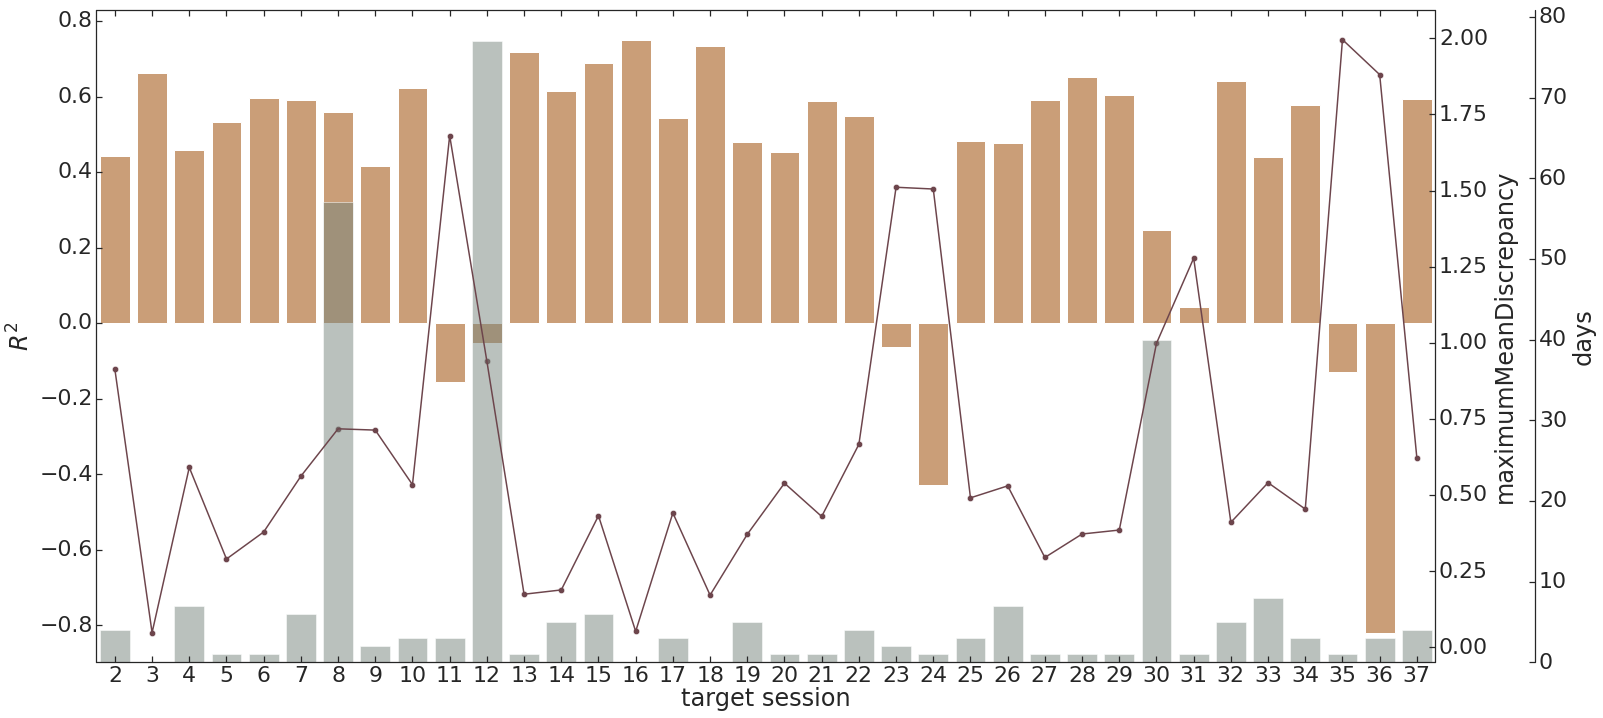

In [10]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist

sns.set_theme(style='white', font_scale=2)

df = pd.read_csv('./results/experiments/experiments_maximumMeanDiscrepancy.csv')

df = df[(df['targetSessionIndex'] - df['sourceSessionIndex'] == 1)]

df = df.groupby(['sourceSessionIndex', 'targetSessionIndex']).mean().reset_index(drop=False)
df['sourceSessionIndex'] = df['sourceSessionIndex'] + 1
df['targetSessionIndex'] = df['targetSessionIndex'] + 1
df['sourceSessionIndex'] = df['sourceSessionIndex'].astype(str)
df['targetSessionIndex'] = df['targetSessionIndex'].astype(str)

df['x'] = df['sourceSessionIndex'] + '-' + df['targetSessionIndex']

df['deltaDay'] = [4, 0, 7, 1, 1, 6, 57, 2, 3, 3, 77, 1, 5, 6, 0, 3, 0, 5, 1, 1, 4, 2, 1, 3, 7, 1, 1, 1, 40, 1, 5, 8, 3, 1, 3, 4]

# fig, ax1 = plt.subplots(figsize=(15, 12))
host = host_subplot(111, axes_class=axisartist.Axes) # update
plt.rcParams["figure.figsize"] = (24, 12) # update
# fig, ax = plt.subplots(1, 1, figsize=(15, 12))
# ax1 = host.twinx()
ax2 = host.twinx()
ax3 = host.twinx()

ax3.axis["right"] = ax3.new_fixed_axis(loc="right", offset=(100, 0)) # update
# ax1.axis['left'].toggle(all=False) # update
# ax1.axis["left"] = ax1.new_fixed_axis(loc="left", offset=(-100, 0)) # update
ax2.axis["right"].toggle(all=True) # update


sns.lineplot(data=df, x='x', y='maximumMeanDiscrepancy', ax=ax2, color='#6D454C')
sns.scatterplot(data=df, x='x', y='maximumMeanDiscrepancy', ax=ax2, s=40, color='#6D454C')
sns.barplot(data=df, x='x', y='deltaDay', ax=ax3, alpha=0.5, color='#73877B')
sns.barplot(data=df, x='x', y='target_r_square', ax=host, color='#D89D6A')


host.set_xticklabels([str(i) for i in range(2, 38, 1)], rotation=45)
host.set_xlabel('target session')
host.set_ylabel('$R^2$')
ax3.set_ylabel('days')

plt.show()